In [1]:
import numpy as np
import cv2
import glob
import keras
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, Input, Flatten, Dense, MaxPooling2D, Activation,MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
train_direct = "chest_xray/train/"
test_direct = "chest_xray/test/"
im_size = 200
batch_size = 32

def dir_img_lab(dir):
    
    norm_img = glob.glob(dir+"NORMAL/*.jpeg")
    norm_labels = np.array(['normal']*len(norm_img))

    pnm_img = glob.glob(dir+"PNEUMONIA/*.jpeg")
    pnm_labels = np.array(list(map(lambda x: x.split("_")[2],pnm_img)))

    return norm_img,norm_labels,pnm_img,pnm_labels

trn_norm_img, trn_norm_lab, trn_pnm_img, trn_pnm_lab = dir_img_lab(train_direct)
tst_norm_img, tst_norm_lab, tst_pnm_img, tst_pnm_lab = dir_img_lab(test_direct)

In [3]:
def get_x(files):
    train_x = np.zeros((len(files), im_size, im_size, 1), dtype = 'float32')
    
    for i, img_file in enumerate(files):
        img = cv2.resize(cv2.imread(img_file, cv2.IMREAD_GRAYSCALE), ((im_size,im_size)))
        img_array = np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0)
        train_x[i] = img_array.reshape(img_array.shape[1],img_array.shape[2],1)
    return train_x

trn_norm_x= get_x(trn_norm_img)
trn_pnm_x= get_x(trn_pnm_img)
tst_norm_x= get_x(tst_norm_img)
tst_pnm_x= get_x(tst_pnm_img)

In [4]:
print("train normal array shape :",trn_norm_x.shape)
print("train pneumonia array shape :",trn_pnm_x.shape)
print("\ntest normal array shape :",tst_norm_x.shape)
print("test pneumonia array shape :",tst_pnm_x.shape)

train normal array shape : (1341, 200, 200, 1)
train pneumonia array shape : (3875, 200, 200, 1)

test normal array shape : (234, 200, 200, 1)
test pneumonia array shape : (390, 200, 200, 1)


In [7]:
x_train = np.append(trn_norm_x,trn_pnm_x,axis=0)
y_train = np.append(trn_norm_lab,trn_pnm_lab)

x_test = np.append(tst_norm_x,tst_pnm_x,axis=0)
y_test = np.append(tst_norm_lab,tst_pnm_lab)

encoder = OneHotEncoder(sparse=False)
y_train_enc= encoder.fit_transform(y_train.reshape(-1, 1))
y_test_enc= encoder.fit_transform(y_test.reshape(-1, 1))


ERROR! Session/line number was not unique in database. History logging moved to new session 997


In [8]:
y_train.shape, y_test.shape, y_train_enc.shape, y_test_enc.shape

((5216,), (624,), (5216, 3), (624, 3))

In [9]:
train_datagen = ImageDataGenerator(rotation_range = 45,
                                  width_shift_range= 0.2,
                                  height_shift_range= 0.2,
                                  shear_range= 0.2,
                                  zoom_range= 0.25,
                                  horizontal_flip= True,
                                  fill_mode= 'nearest')

train_generator = train_datagen.flow(x_train,
                                    y_train_enc,
                                    batch_size = batch_size)

test_generator = ImageDataGenerator().flow(x_test,
                                          y_test_enc,
                                          batch_size= batch_size)

In [10]:
#Input with the shape of (200,200,1)

model = Sequential()


model.add(Conv2D(16, (3,3), activation='relu', strides =(1,1) ,padding='same', input_shape=(im_size,im_size,1)))
model.add(Conv2D(32, (3, 3),activation='relu',strides=(1, 1),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(16, (3,3), activation='relu', strides =(1,1) ,padding='same', input_shape=(im_size,im_size,1)))
model.add(Conv2D(32, (3, 3),activation='relu',strides=(1, 1),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3,3), activation='relu', strides =(1,1) ,padding='same', input_shape=(im_size,im_size,1)))
model.add(Conv2D(32, (3, 3),activation='relu',strides=(1, 1),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(50, activation= 'relu'))

model.add(Dense(3, activation='softmax'))
# model.add(Dense(3))
# model.add(Activation('softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 16)      4624      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 16)       

In [11]:
#epochs for model training and learning rate for optimizer
epochs = 20
learning_rate = 0.01

model.compile( optimizer = Adam(lr=0.001),
      loss='categorical_crossentropy',
      metrics=["accuracy"])

In [12]:
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)

Epoch 1/20
163/163 [==============================] - 252s 2s/step - loss: 2.3168 - accuracy: 0.5481 - val_loss: 0.8163 - val_accuracy: 0.6941
Epoch 2/20
163/163 [==============================] - 257s 2s/step - loss: 0.7757 - accuracy: 0.6614 - val_loss: 0.6564 - val_accuracy: 0.7247
Epoch 3/20
163/163 [==============================] - 288s 2s/step - loss: 0.7393 - accuracy: 0.6852 - val_loss: 0.6833 - val_accuracy: 0.7314
Epoch 4/20
163/163 [==============================] - 278s 2s/step - loss: 0.7335 - accuracy: 0.6827 - val_loss: 0.7560 - val_accuracy: 0.6943
Epoch 5/20
163/163 [==============================] - 259s 2s/step - loss: 0.7025 - accuracy: 0.7099 - val_loss: 1.1827 - val_accuracy: 0.5963
Epoch 6/20
163/163 [==============================] - 258s 2s/step - loss: 0.7428 - accuracy: 0.6779 - val_loss: 0.5979 - val_accuracy: 0.6588
Epoch 7/20
163/163 [==============================] - 299s 2s/step - loss: 0.6968 - accuracy: 0.7095 - val_loss: 0.6172 - val_accuracy: 0.6672

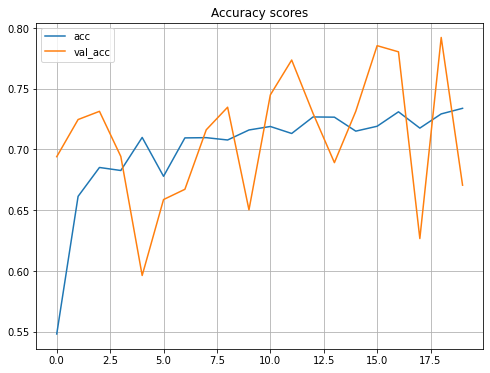

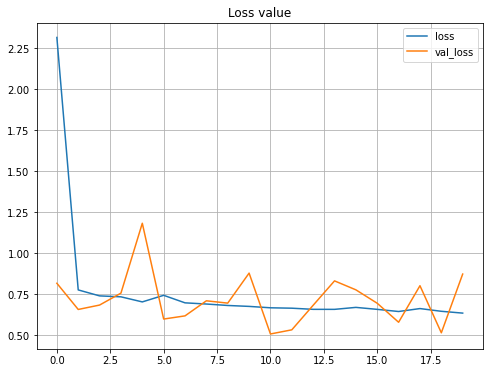

In [15]:
#Accuracy Graph
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.grid()
plt.show()

#Loss Graph
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.show()

In [16]:
model.save("new model")

In [17]:
model = load_model("new model")

In [20]:
labels = ['bacteria','normal','virus']

#confusion matrix
y_pred = model.predict(x_test)
#transforming label back to original
y_pred = encoder.inverse_transform(y_pred)


ERROR! Session/line number was not unique in database. History logging moved to new session 1003


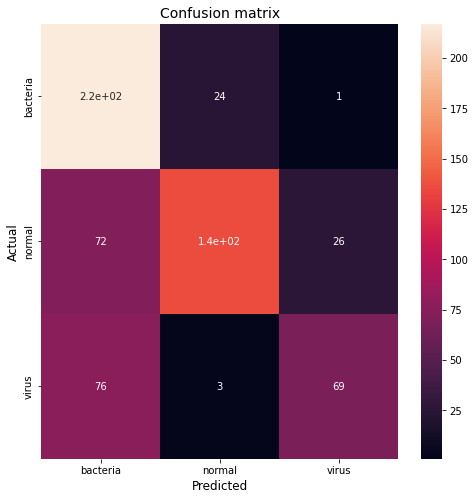

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#matrix of Actual vs Prediction data
c_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix',fontsize=14)
sns.heatmap(c_matrix, xticklabels=labels,yticklabels=labels,  annot=True)
plt.xlabel("Predicted",fontsize=12)
plt.ylabel("Actual",fontsize=12)
plt.show()

In [21]:
for i in range(230,280,3):
    pred = model.predict(x_test)[i]

    #Display the x-ray image
    cv2.imshow("Prediction",x_test[i])

    #uncomment below line only when working on google colab
    #cv2_imshow(x_test[i])

    print("Actual :",y_test[i]," Predicted :",labels[np.argmax(pred)])

ERROR! Session/line number was not unique in database. History logging moved to new session 1001
Actual : normal  Predicted : bacteria
Actual : normal  Predicted : normal
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : normal
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : normal
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria
Actual : bacteria  Predicted : bacteria


In [25]:
i = 2
pred = model.predict(x_test)[i]
cv2.imshow("Prediction",x_test[i])
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Actual :",y_test[i]," Predicted :",labels[np.argmax(pred)])

Actual : normal  Predicted : bacteria
